# Vehicle Detection Project

## The steps/goals of this project are the following
* Extract the Histogram of Oriented Gradients (HOG) feature of the vehicle images. 
* Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.
* Perform the two steps above on a labeled training set of images and train a Linear SVM classifier.
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load dataset
My dataset is consisted of two parts:
1. Subset of [Vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [Non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) data that provided for this project, which come from combination of the GTI vehicle image database, the KITTI vision benchmark suite, and examples extracted from the project video itself.  
2. Examples from [Udacity data](https://github.com/udacity/self-driving-car/tree/master/annotations)

In [1]:
import cv2
import os
import csv
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import time
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label

In [2]:
# Read training images path
def load_data(data_path):
    folders = os.listdir(data_path)
    imgs = []
    for folder in folders:
        if folder == '.DS_Store':
            continue
        else:
            imgs.append(glob.glob( data_path + '/' + folder + '/*.jpeg'))
    return np.concatenate(imgs)
   
proj_cars = load_data('vehicles_smallset')
proj_notcars = load_data('non-vehicles_smallset') 

print(len(proj_cars))
print(len(proj_notcars))

1196
1125


In [3]:
"""
# Extract training images from Udacity
with open('object-detection-crowdai/labels.csv') as f:
    file = csv.reader(f)
    uda_cars = []
    uda_trucks = []
    uda_pedestrians = []
    for i, line in enumerate(file):
        if i > 0 :
            if line[5] == 'Car':
                uda_cars.append(line)
            elif line[5] == 'Truck':
                uda_trucks.append(line)
            elif line[5] == 'Pedestrian':
                uda_pedestrians.append(line)

print("The number of car images in Udacity data: ", len(uda_cars))
print("The number of truck images in Udacity data: ", len(uda_trucks))
print("The number of pedestrian images in Udacity data: ", len(uda_pedestrians))

def extract_vehicle(list, folder):
    vehicle_paths = []
    for i, line in enumerate(list):
        file_name = line[4]
        img = mpimg.imread('object-detection-crowdai/'+ str(file_name))
        crop_img = img[int(line[1]):int(line[3])-1, int(line[0]):int(line[2])-1]
        crop_img = cv2.resize(crop_img,(64,64))
        path = folder + str(i) + '.jpg'
        plt.imsave(path, crop_img)
        vehicle_paths.append(path)
    return vehicle_paths

t = time.time()
uda_cars_extract = extract_vehicle(uda_cars, 'udacity_data/car/')
uda_trucks_extract = extract_vehicle(uda_cars, 'udacity_data/truck/')
uda_pedestrians_extract = extract_vehicle(uda_pedestrians, 'udacity_data/pedestrian/')
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract vehicles from Udacity data...')
"""

'\n# Extract training images from Udacity\nwith open(\'object-detection-crowdai/labels.csv\') as f:\n    file = csv.reader(f)\n    uda_cars = []\n    uda_trucks = []\n    uda_pedestrians = []\n    for i, line in enumerate(file):\n        if i > 0 :\n            if line[5] == \'Car\':\n                uda_cars.append(line)\n            elif line[5] == \'Truck\':\n                uda_trucks.append(line)\n            elif line[5] == \'Pedestrian\':\n                uda_pedestrians.append(line)\n\nprint("The number of car images in Udacity data: ", len(uda_cars))\nprint("The number of truck images in Udacity data: ", len(uda_trucks))\nprint("The number of pedestrian images in Udacity data: ", len(uda_pedestrians))\n\ndef extract_vehicle(list, folder):\n    vehicle_paths = []\n    for i, line in enumerate(list):\n        file_name = line[4]\n        img = mpimg.imread(\'object-detection-crowdai/\'+ str(file_name))\n        crop_img = img[int(line[1]):int(line[3])-1, int(line[0]):int(line[2]

In [4]:
uda_cars = glob.glob('udacity_data/car/*.jpg')
# Get 5000 samples from Udacity cars
random_uda_car_inds = np.random.randint(0, len(uda_cars), 5000)
random_uda_cars = [uda_cars[i] for i in random_uda_car_inds]

# Combine the vehicle data and udacity data
cars = np.concatenate((proj_cars, random_uda_cars))
# notcars = np.tile(proj_notcars, 2)

# cars = proj_cars
notcars = proj_notcars

print('The number of vehicle images: ', len(cars))
print('The number of non-vehicle images: ', len(notcars))

The number of vehicle images:  6196
The number of non-vehicle images:  1125


The shape of images:  (64, 64)


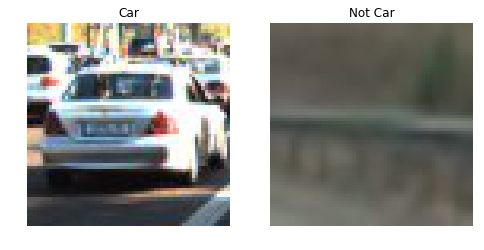

In [5]:
# Generator a random index to look at an example of one each of vehicles and non-vehicles
ind = np.random.randint(0, 100)
car = cv2.imread(cars[ind])
car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
notcar = cv2.imread(notcars[ind])
notcar = cv2.cvtColor(notcar, cv2.COLOR_BGR2RGB)
print('The shape of images: ', (car.shape[1], car.shape[0]))

# Display the vehicle example and not-vehicle example
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(car)
axes[0].set_title('Car')
axes[0].set_axis_off()
axes[1].imshow(notcar)
axes[1].set_title('Not Car')
axes[1].set_axis_off()
plt.show()


## Explore HOG Fearures
I use scikit-image`hog()` function to extract Histogram of Oriented Gradient features and explore the car hog features with the combination of parameters orient, pix_per_cell, and cell_per_block to get a feel for what combination wiil give the best results.

In [27]:
# Define a function to return Hog features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, feat_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise=vis, feature_vector=feat_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys', transform_sqrt=False, 
                       visualise=vis, feature_vector=feat_vec)
        return features

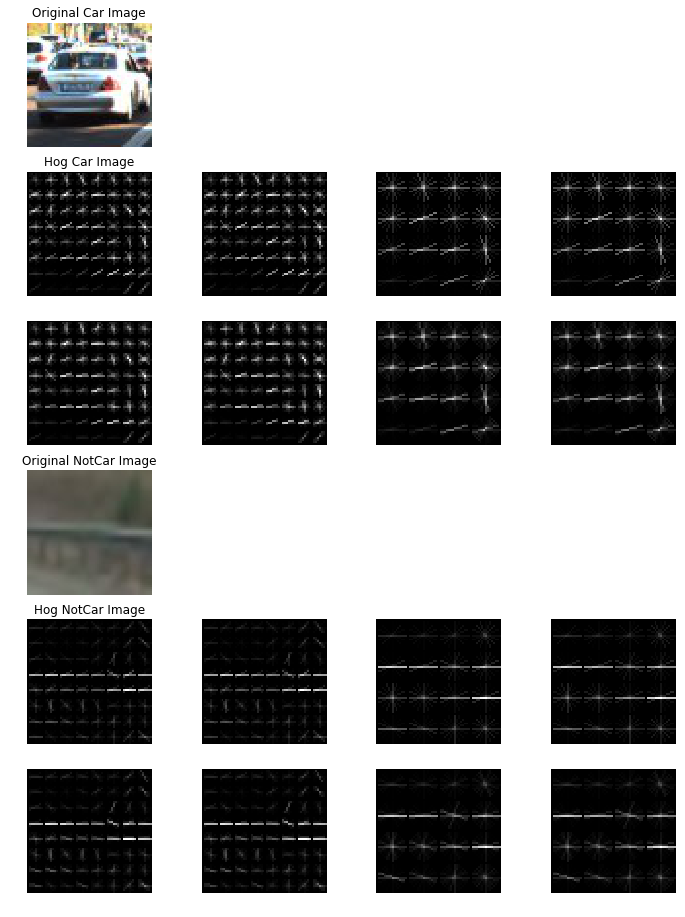

In [7]:
# Conver the car image and notcar image into grayscale
car_gray = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
notcar_gray = cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY)

# Visulize the hog features with different combination of parameters.
orient = [8, 16]
pix_per_cell = [8, 16]
cell_per_block = [2, 4]
car_hog_ls = []
notcar_hog_ls = []
for i in orient:
    for j in pix_per_cell:
        for k in cell_per_block:
            _, car_hog_image = get_hog_features(car_gray, orient=i, pix_per_cell=j, cell_per_block=k, feat_vec=False)
            car_hog_ls.append(car_hog_image)
            _, notcar_hog_image = get_hog_features(notcar_gray, orient=i, pix_per_cell=j, cell_per_block=k, feat_vec=False)
            notcar_hog_ls.append(notcar_hog_image)

# Plot the hog features visualization
fig, axes = plt.subplots(6, 4, figsize=(12,16))
for i in range(int(len(car_hog_ls)/2)):
    axes[0][i].imshow(np.ones_like(car)*255)
    axes[0][i].set_axis_off()
    axes[1][i].imshow(car_hog_ls[i], cmap='gray')
    axes[1][i].set_axis_off()
    axes[2][i].imshow(car_hog_ls[i+4], cmap='gray')
    axes[2][i].set_axis_off()
    axes[3][i].imshow(np.ones_like(notcar)*255)
    axes[3][i].set_axis_off()
    axes[4][i].imshow(notcar_hog_ls[i], cmap='gray')
    axes[4][i].set_axis_off()
    axes[5][i].imshow(notcar_hog_ls[i+4], cmap='gray')
    axes[5][i].set_axis_off()

axes[0][0].imshow(car, cmap='gray')
axes[0][0].set_title('Original Car Image')
axes[0][0].set_axis_off()
axes[1][0].set_title('Hog Car Image')

axes[3][0].imshow(notcar, cmap='gray')
axes[3][0].set_title('Original NotCar Image')
axes[3][0].set_axis_off()
axes[4][0].set_title('Hog NotCar Image')

plt.show()

Pararmeters orient=16 will give better orientations, pix_per_cell=8 will arrive at better shapes, cell_per_block=2 & cell_per_block=4 has nearly the same performance.

## Explore the Color Histogram Fearures
I combine the raw pixel values and histogram features and explore the intensity of them in different color space.

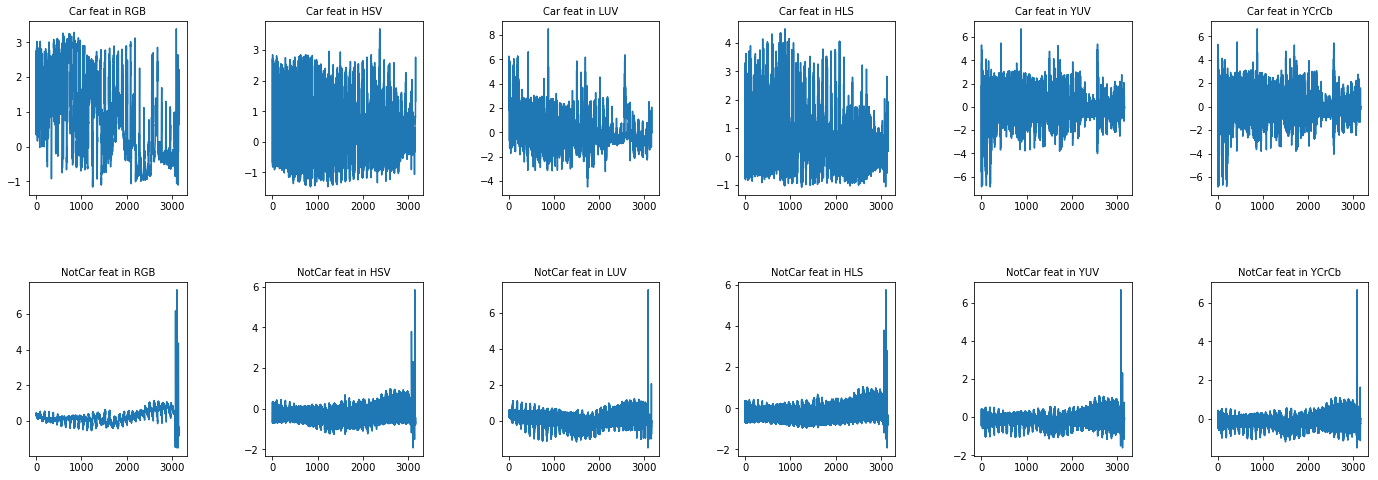

In [28]:
# Define a function to get raw pixel values
def bin_spatial(img, size=(32,32)):
    features = cv2.resize(img, size).ravel()
    return features

# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0,256)):
    ch1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ch2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    ch3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((ch1_hist[0], ch2_hist[0], ch3_hist[0]))  
    return hist_features

# Combine the raw pixel values and color histogram features
def hist_features(imgs, cspace='RGB', spatial_size=(32,32), hist_bins=32, hist_range=(0,256)):
    features = []
    for file in imgs:
        img = cv2.imread(file)
        if cspace == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif cspace == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif cspace == "YCrCb":
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        features.append(np.concatenate((spatial_features, hist_features)))
    return features
        
# Explore the features of the car and notcar image in different color space 
color_space = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
car_feat_in_cs = []
notcar_feat_in_cs = []
for cs in color_space:
    car_hist_feat = hist_features(cars, cspace=cs)
    notcar_hist_feat = hist_features(notcars, cspace=cs)
    
    # Normalize the features
    X = np.vstack((car_hist_feat, notcar_hist_feat)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    car_feat_in_cs.append(scaled_X[ind])
    notcar_feat_in_cs.append(scaled_X[ind+len(cars)])

# Plot the car features and notcar features
fig, axes = plt.subplots(2,6,figsize=(24,8))
fig.subplots_adjust(wspace = 0.5, hspace =0.5)
for i, (car_feat, notcar_feat) in enumerate(zip(car_feat_in_cs, notcar_feat_in_cs)):
    axes[0][i].plot(car_feat)
    axes[0][i].set_title('Car feat in ' + color_space[i], fontsize=10)
    axes[1][i].plot(notcar_feat)
    axes[1][i].set_title('NotCar feat in ' + color_space[i], fontsize=10)
plt.show()

The intensity of features in YUV color space are exactly same as it in YCrCb color space. YCrCb and LUV color space give the stronger intensity of features.

## Apply a color transform and append binned color features, as well as histograms of color, to the HOG feature vector.

In [31]:
# Define a function to combine binned color features, color histogram features and hog features
def extract_features(img, spatial_feat=True, hist_feat=True, hog_feat=True, hog_channel='ALL',
                    orient=14, pix_per_cell=8, cell_per_block=2):
    img_features = []
    # Convert the image into YCrCb color space
    feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image)
        img_features.append(spatial_features)
    
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image)
        img_features.append(hist_features)
    
    # Compute hog features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                features = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feat_vec=False)
                hog_features.append(features)
            hog_features = np.concatenate(hog_features).ravel()
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, 
                                                cell_per_block, vis=False, feat_vec=False).ravel()
        img_features.append(hog_features)
    return np.concatenate(img_features)    

## Perform feature extraction on labeled training set of images and train a Linear SVM classifier.
I use SVM `LinearSVC` to train the classifier. Before training, I extract features of training data set and add labels to car_features and notcar_features. Then I Shuffle the data and put 20% of the data into validation data. After that I normalize the training featrues and validation features using `StandardScaler()`.

In [32]:
# Extract features of images from the combined datasets, into car_features and notcar_features.
t = time.time()
car_features = [extract_features(cv2.imread(img)) for img in cars]
notcar_features = [extract_features(cv2.imread(img)) for img in notcars]
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features')

58.24 Seconds to extract features


In [33]:
# Combine the car_features and notcar_features 
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Add labels to the car_features and notcar_features
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#rand_state = np.random.randint(0, 100)
X, y = shuffle(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Normalize features
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [34]:
# Use a linear SVC 
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
acc = svc.score(X_test, y_test)
print('Test Accuracy of SVC = ', round(acc, 4))

# Check the prediction time for 10 samples
t = time.time()
n_predict = 10
print('My SVC precicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'lables: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict, 'labels with SVC')  

86.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9631
My SVC precicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 lables:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00239 Seconds to predict 10 labels with SVC


## Implement a sliding-window technique and use the trained classifier to search for vehicles in images
I use a given window with the size of (64,64) to silde on the image and return a list of window position. Then I apply the trained classifier to predict if there is a car on a window, and if YES, append the window position into a list. The last step is draw the windows on image.

In [35]:
# Define a function to draw boxes on an image
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=3):
    out_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for bbox in bboxes:
        cv2.rectangle(out_img, bbox[0], bbox[1], color, thick)
    return out_img

# Define a function to slide a given window on an image
def slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 656], xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1-xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1-xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    
    window_list=[]
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

# Define a function that inputs an image and the list of windows to be searched, returns windows for positive detections
def search_windows(img, windows, clf, scaler):
    on_windows = []
    for window in windows:
        # Extract the window from original image
        subimg = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]],(64,64))       
        # Extract features for that window using extract_features()
        features = extract_features(subimg)
        # Scale extracted features to be fed to classifier
        scaled_features = scaler.transform(features.reshape(1,-1))   
        # Predict using the classifier
        prediction = clf.predict(scaled_features)
        # Return windows for positive detections
        if prediction == 1:
            on_windows.append(window)
    return on_windows

Using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, I get a nice result.  Here are some example images:

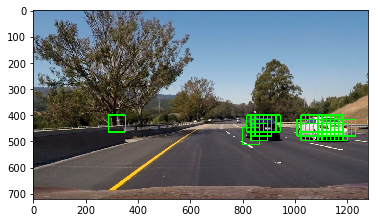

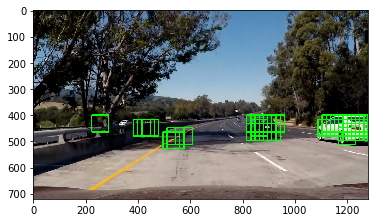

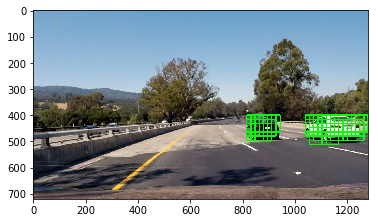

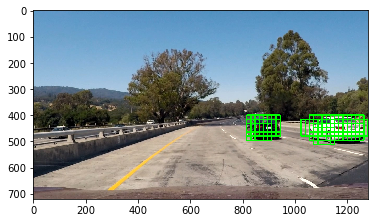

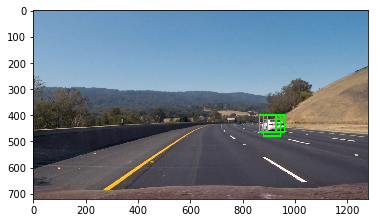

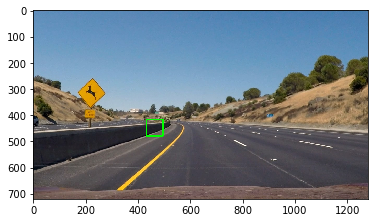

In [40]:
img_files = glob.glob('test_images/test*.jpg')
for file in img_files:
    img = cv2.imread(file)
    windows = slide_window(img)
    hot_windows = search_windows(img, windows, svc, X_scaler)
    window_img = draw_boxes(img, hot_windows)
    plt.imshow(window_img)
    plt.show()


## Use hog sub-sampling window search to improve searching efficience
Instead of extracting hog features on each window, extracting hog features only once and then sub-sumple it to each window will save a lot of time. I first extract the area of the image that the car will occur and convert it into YCrCb color space. I then compute the hog features and define the blocks in x,y direction as well as the steps that a block will slide. In every step, sub-sample the hog features and extract binned color features as well as histogram features of the block. At last, apply the trained classifier to predict if a car on the block, if YES, append the block into the bboxes list.

In [29]:
orient = 14
pix_per_cell = 8
cell_per_block = 2

ystart = 400
ystop = 656
scale = 1.1

# Using hog sub-sampling to extract features and make predictions 
def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block):
    
    draw_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_BGR2YCrCb)
    
    bboxes = []
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feat_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feat_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feat_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg)
            hist_features = color_hist(subimg)

            # Scale features and make a prediction
            test_features = np.hstack((spatial_features, hist_features, hog_features)) 
            scaled_features = scaler.transform(test_features.reshape(1, -1))    
            test_prediction = svc.predict(scaled_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img, box[0], box[1], (0,0,255), 6) 
                bboxes.append(box)
    return bboxes, draw_img


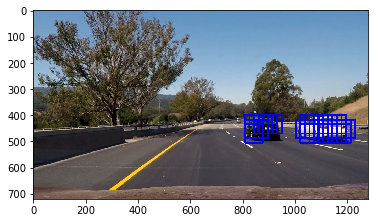

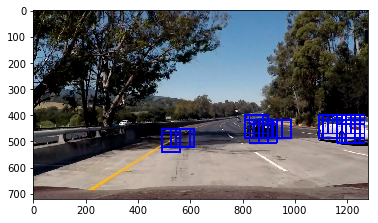

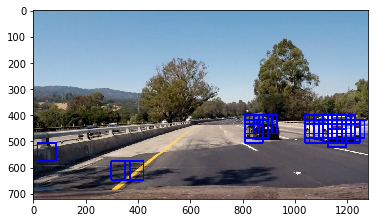

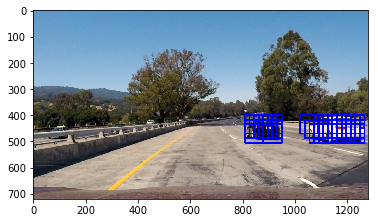

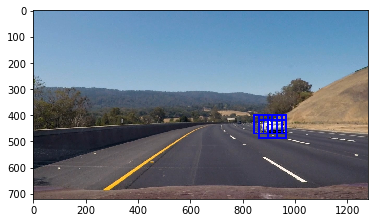

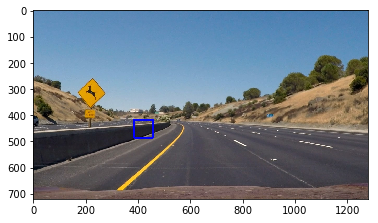

In [36]:
# Display some example images using the find_cars function
for file in img_files:
    img = cv2.imread(file)
    _, out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    plt.imshow(out_img)
    plt.show()

## Apply a heat threshold to remove false detections
I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

In [37]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img 

In [38]:
def process_img(img, heat_vis=False):
    hot_windows, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block)
    #windows = slide_window(img)
    #hot_windows = search_windows(img, windows, svc, X_scaler)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list        
    heat = add_heat(heat, hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 3)
    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    if heat_vis == True:
        return draw_img, heatmap
    else:
        return draw_img

Here's some examples showing the heatmap

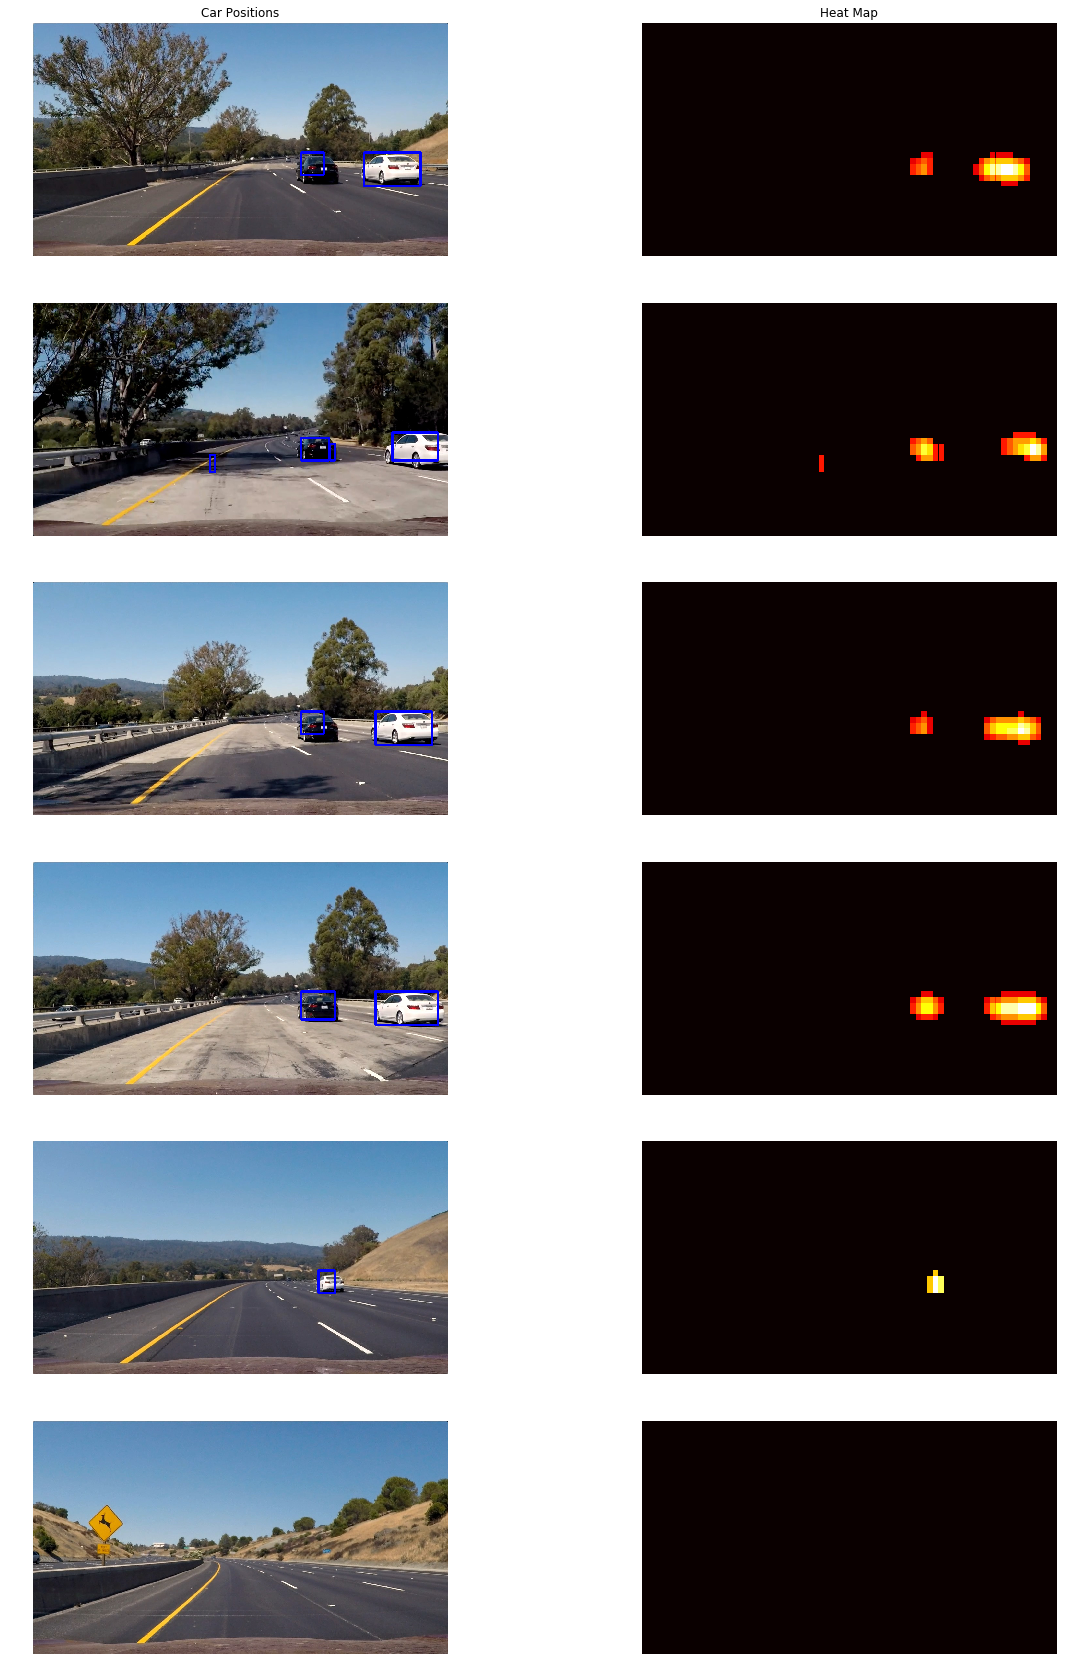

In [39]:
draw_imgs = []
heatmaps = []
for i in range(len(img_files)):
    img = cv2.imread(img_files[i])
    draw_img, heatmap = process_img(img, heat_vis=True)
    # Save output images in output_images file
    path1 = 'output_images/' + 'car_positions' + str(i+1) + '.jpg'
    path2 = 'output_images/' + 'heatmap' + str(i+1) + '.jpg'
    plt.imsave(path1, draw_img)
    plt.imsave(path2, heatmap)
    draw_imgs.append(draw_img)
    heatmaps.append(heatmap)

fig, axes = plt.subplots(6, 2, figsize=(20, 30))
for i in range(len(draw_imgs)):
    axes[i][0].imshow(draw_imgs[i])
    axes[i][0].set_axis_off()
    axes[i][1].imshow(heatmaps[i], cmap='hot')
    axes[i][1].set_axis_off()
axes[0][0].set_title('Car Positions')
axes[0][1].set_title('Heat Map')
plt.show()

In [25]:
# Apply the pipeline to the project video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def cvt_color(img):
    img_out = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img_out

def pipeline(img):
    cvt_img = cvt_color(img)
    img_out = process_img(cvt_img)
    return img_out

output1 = 'videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video videos_output/project_video.mp4
[MoviePy] Writing video videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [23:05<00:01,  1.10s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos_output/project_video.mp4 

CPU times: user 22min 49s, sys: 24.8 s, total: 23min 14s
Wall time: 23min 6s


In [26]:
HTML("""
<video width="960" height="540" controls> <source src="{0}"> </video>
""".format(output1))

## Discussion
1. I tried a lot of combinations of parameters, and orient=14 & pix_per_cell=8 & cell_per_block=2 & spatial_size=(32,32) & nbins=32 & scale=1.1 returned the best results. However, the results is not so good.
2. The dectection performace is bad while the light is insufficient. I thought maybe the data is not enough, so I used the full set of vehicle and non-vehice images. But the result was even worse.